In [1]:
import pandas as pd
import numpy as np
import ast
import re
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
summary_df = pd.read_csv('../data/processed/structured_dataset_with_discharge_summaries_ner_features.train.csv')

print(f"Dataset shape: {summary_df.shape}")
print(f"Columns: {summary_df.columns.tolist()}")
summary_df.head()

Dataset shape: (1046, 33)
Columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'admission_type', 'discharge_location', 'gender', 'dod', 'age_at_admit', 'length_of_stay_days', 'icd10_codes', 'icd10_descriptions', 'num_icd10_codes', 'primary_icd10', 'icd_version', 'primary_icd10_desc', 'primary_pdgm_bucket_simple', 'procedures_icd10', 'num_procedures_total', 'meds_discharge_like', 'medication_count', 'policy', 'discharge_summary', 'diagnosis_codes', 'model', 'true_icd_codes', 'missing_codes', 'disease_entity_count', 'drug_entity_count', 'anatomy_entity_count', 'disease_entities', 'drug_entities', 'anatomy_entities']


,subject_id,hadm_id,admittime,dischtime,admission_type,discharge_location,gender,dod,age_at_admit,length_of_stay_days,...,diagnosis_codes,model,true_icd_codes,missing_codes,disease_entity_count,drug_entity_count,anatomy_entity_count,disease_entities,drug_entities,anatomy_entities
0,17504528,20171885,2137-06-17 20:40:00,2137-06-20 16:41:00,DIRECT EMER.,HOME,F,2142-07-24,56,2.834028,...,['E118' 'Z5181' 'I5032' 'K219' 'D473' 'I10' 'I...,gpt-4o-mini,['I5032' 'E118' 'I10' 'E785' 'I2510' 'I071' 'D...,['Z7901' 'I272' 'E039' 'D72829' 'F419' 'E785' ...,19,13,7,"[{'entity_group': 'DISEASE', 'score': np.float...","[{'entity_group': 'CHEM', 'score': np.float32(...","[{'entity_group': 'Anatomy', 'score': np.float..."
1,14273001,20371042,2187-10-19 19:00:00,2187-10-21 18:13:00,OBSERVATION ADMIT,HOME,F,2188-03-27,73,1.967361,...,['Z7901' 'Z87891' 'E039' 'Y929' 'I5031' 'E785'...,gpt-4o-mini,['I5031' 'I82501' 'C7931' 'C3431' 'E039' 'Z790...,[],13,12,9,"[{'entity_group': 'DISEASE', 'score': np.float...","[{'entity_group': 'CHEM', 'score': np.float32(...","[{'entity_group': 'Anatomy', 'score': np.float..."
2,11357031,27612249,2139-01-17 21:04:00,2139-01-22 18:00:00,OBSERVATION ADMIT,HOME HEALTH CARE,M,2144-10-28,58,4.872222,...,['I5033'],gpt-4o-mini,['I5033' 'J9692' 'J9691' 'E870' 'E872' 'E662' ...,['E1140' 'I272' 'E872' 'I129' 'Z6833' 'E11319'...,12,9,8,"[{'entity_group': 'DISEASE', 'score': np.float...","[{'entity_group': 'CHEM', 'score': np.float32(...","[{'entity_group': 'Anatomy', 'score': np.float..."
3,13673554,25741865,2176-02-25 19:39:00,2176-03-02 17:30:00,OBSERVATION ADMIT,HOME HEALTH CARE,M,2180-11-21,71,5.910417,...,['I129' 'N184' 'I5033' 'N179' 'Z951' 'C9110' '...,gpt-4o-mini,['I5033' 'C9110' 'J918' 'N184' 'N179' 'I129' '...,[],15,9,12,"[{'entity_group': 'DISEASE', 'score': np.float...","[{'entity_group': 'CHEM', 'score': np.float32(...","[{'entity_group': 'Anatomy', 'score': np.float..."
4,19017808,20589756,2183-01-05 21:59:00,2183-01-08 18:35:00,OBSERVATION ADMIT,HOME HEALTH CARE,F,2184-11-16,77,2.858333,...,['N2889' 'K7460' 'I8510' 'I5032' 'I4891' 'N179...,gpt-4o-mini,['I5032' 'I8510' 'N179' 'I272' 'K7460' 'N390' ...,['I272' 'Y929' 'S5001XA' 'W19XXXA' 'I10' 'Z850...,14,7,11,"[{'entity_group': 'DISEASE', 'score': np.float...","[{'entity_group': 'CHEM', 'score': np.float32(...","[{'entity_group': 'Anatomy', 'score': np.float..."


In [2]:
from chromadb.utils import embedding_functions
from chromadb.config import Settings
import chromadb

sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name = "lokeshch19/ModernPubMedBERT")

chroma_client = chromadb.PersistentClient(path="../icd10_embeddings", settings=Settings(allow_reset=True))

chroma_collection = chroma_client.get_collection("icd10_embeddings", embedding_function=sentence_transformer_ef)



In [3]:
# Helper function to parse entity lists from string representation
def parse_entity_list(entity_str):
    """
    Parse entity list from string representation.
    Returns a list of entity text strings.
    """
    if pd.isna(entity_str) or entity_str == '[]':
        return []
    
    try:
        # got stored with np.float32(...)
        # need to clean it
        cleaned = re.sub(r'np\.float32\(([^)]+)\)', r'\1', entity_str)
        # Use ast.literal_eval to safely parse the string representation
        entities = ast.literal_eval(cleaned)
        # Extract just the 'word' field from each entity dict
        return [ent.get('word', '').strip() for ent in entities if isinstance(ent, dict) and 'word' in ent]
    except:
        return []

# Test the parser on a sample
sample_entities = summary_df['disease_entities'].iloc[0]
print(f"Raw entity string (first 200 chars): {str(sample_entities)[:200]}")
print(f"Parsed entities: {parse_entity_list(sample_entities)[:5]}")

Raw entity string (first 200 chars): [{'entity_group': 'DISEASE', 'score': np.float32(0.6947583), 'word': ' diastolic (congestive) heart failure', 'start': 156, 'end': 193}, {'entity_group': 'DISEASE', 'score': np.float32(0.95489573), 'w
Parsed entities: ['diastolic (congestive) heart failure', 'diastolic heart failure', 'shortness of breath', 'fatigue', 'type 2 diabetes mellitus']


In [4]:
# the entity string serialized the numpy floats like 'score': np.float32(0.6947583) and this causes an error with ast.literal_eval
# i need to get rid of it
# Replace np.float32(...) with just the numeric value
cleaned = re.sub(r'np\.float32\(([^)]+)\)', r'\1', sample_entities)

# Now parse it
result = ast.literal_eval(cleaned)
print(result)

[{'entity_group': 'DISEASE', 'score': 0.6947583, 'word': ' diastolic (congestive) heart failure', 'start': 156, 'end': 193}, {'entity_group': 'DISEASE', 'score': 0.95489573, 'word': ' diastolic heart failure', 'start': 316, 'end': 340}, {'entity_group': 'DISEASE', 'score': 0.9260766, 'word': ' shortness of breath', 'start': 360, 'end': 380}, {'entity_group': 'DISEASE', 'score': 0.62120926, 'word': ' fatigue', 'start': 408, 'end': 416}, {'entity_group': 'DISEASE', 'score': 0.9455447, 'word': ' type 2 diabetes mellitus', 'start': 456, 'end': 481}, {'entity_group': 'DISEASE', 'score': 0.8956117, 'word': ' hypertension', 'start': 482, 'end': 495}, {'entity_group': 'DISEASE', 'score': 0.9361858, 'word': ' hyperlipidemia', 'start': 496, 'end': 511}, {'entity_group': 'DISEASE', 'score': 0.8236439, 'word': ' atherosclerotic heart disease', 'start': 516, 'end': 546}, {'entity_group': 'DISEASE', 'score': 0.95700103, 'word': ' heart failure', 'start': 617, 'end': 631}, {'entity_group': 'DISEASE',

In [5]:
# Parse ground truth ICD-10 codes
def parse_icd_codes(icd_str):
    """Parse ICD-10 codes from string representation."""
    if pd.isna(icd_str):
        return []
    # Handle array string format like "['I5032' 'E118' ...]"
    codes = ast.literal_eval(icd_str.replace('\n', '').replace(' ', ','))
    if isinstance(codes, (list, np.ndarray)):
        return [str(c).strip() for c in codes]
    return []
    

# Test parsing
sample_codes = summary_df['true_icd_codes'].iloc[0]
print(f"Sample true codes: {parse_icd_codes(sample_codes)[:10]}")

Sample true codes: ['I5032', 'E118', 'I10', 'E785', 'I2510', 'I071', 'D649', 'I272', 'J45909', 'K219']


In [12]:
sample_codes

"['I5032' 'E118' 'I10' 'E785' 'I2510' 'I071' 'D649' 'I272' 'J45909' 'K219'\n 'F329' 'F419' 'E039' 'M8580' 'I480' 'Z7901' 'D72829' 'D473' 'Z8572'\n 'Z8673' 'Z954' 'Z5181']"

In [6]:
# Parse all entities and ground truth codes for the dataset
print("Parsing entities and ground truth codes...")

summary_df['disease_entities_parsed'] = summary_df['disease_entities'].apply(parse_entity_list)
summary_df['drug_entities_parsed'] = summary_df['drug_entities'].apply(parse_entity_list)
summary_df['anatomy_entities_parsed'] = summary_df['anatomy_entities'].apply(parse_entity_list)
summary_df['true_icd_codes_parsed'] = summary_df['true_icd_codes'].apply(parse_icd_codes)

# Check parsed data
print(f"\nSample parsed data:")
print(f"Disease entities: {summary_df['disease_entities_parsed'].iloc[0][:3]}")
print(f"Drug entities: {summary_df['drug_entities_parsed'].iloc[0][:3]}")
print(f"Anatomy entities: {summary_df['anatomy_entities_parsed'].iloc[0][:3]}")
print(f"True ICD codes: {summary_df['true_icd_codes_parsed'].iloc[0][:5]}")
print(f"\nAverage number of true ICD codes per admission: {summary_df['true_icd_codes_parsed'].apply(len).mean():.2f}")

Parsing entities and ground truth codes...



Sample parsed data:
Disease entities: ['diastolic (congestive) heart failure', 'diastolic heart failure', 'shortness of breath']
Drug entities: ['Enoxaparin', 'Aspirin', 'Levothyroxine']
Anatomy entities: ['heart', 'heart failure. She presented with shortness of breath, lower extremity edema', 'heart']
True ICD codes: ['I5032', 'E118', 'I10', 'E785', 'I2510']

Average number of true ICD codes per admission: 13.95


In [7]:
# Metric calculation functions
def calculate_metrics_at_k(retrieved_codes, true_codes, k):
    """
    Calculate precision, recall, and F1 at k.
    
    Args:
        retrieved_codes: List of retrieved ICD codes (ordered by relevance)
        true_codes: List of ground truth ICD codes
        k: Number of top results to consider
    
    Returns:
        dict with precision, recall, f1
    """
    if len(true_codes) == 0:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    
    # Take top k retrieved codes
    retrieved_k = set(retrieved_codes[:k])
    true_set = set(true_codes)
    
    # Calculate intersection
    correct = retrieved_k.intersection(true_set)
    
    # Precision: correct predictions / total predictions
    precision = len(correct) / k if k > 0 else 0.0
    
    # Recall: correct predictions / total ground truth
    recall = len(correct) / len(true_set) if len(true_set) > 0 else 0.0
    
    # F1 score
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Test metric calculation
test_retrieved = ['A001', 'B002', 'C003', 'D004', 'E005']
test_true = ['A001', 'C003', 'F006']
print(f"Test metrics at k=5: {calculate_metrics_at_k(test_retrieved, test_true, 5)}")

Test metrics at k=5: {'precision': 0.4, 'recall': 0.6666666666666666, 'f1': 0.5}


In [8]:
# Get all ICD codes and documents from ChromaDB for exact matching strategies
print("Fetching all ICD codes from ChromaDB...")

# Get all documents from the collection
all_results = chroma_collection.get(include=['documents', 'metadatas'])

icd_codes_list = all_results['ids']
icd_documents_list = all_results['documents']
icd_metadata_list = all_results['metadatas']

print(f"Total ICD codes in database: {len(icd_codes_list)}")
print(f"Sample code: {icd_codes_list[0]}")
print(f"Sample document: {icd_documents_list[0][:150]}")

Fetching all ICD codes from ChromaDB...
Total ICD codes in database: 2467
Sample code: A020
Sample document: Salmonella enteritis.
Clinical Information: Poisoning caused by ingestion of food harboring species of salmonella. Conditions of raising, shipping, sl


'A020'

In [9]:
# Strategy 1-3: Exact Matching (Case-Insensitive Substring)
def exact_match_strategy(entities, icd_codes_list, icd_documents_list, max_results=100):
    """
    Perform case-insensitive substring matching on entities.
    Returns list of matching ICD codes.
    """
    if not entities:
        return []
    
    matched_codes = []
    matched_scores = []  # Track how many entities matched
    
    # Convert entities to lowercase for matching
    entities_lower = [e.lower() for e in entities if e]
    
    for code, doc in zip(icd_codes_list, icd_documents_list):
        doc_lower = doc.lower()
        match_count = 0
        
        # Check if any entity appears in the document
        for entity in entities_lower:
            if entity in doc_lower:
                match_count += 1
        
        if match_count > 0:
            matched_codes.append(code)
            matched_scores.append(match_count)
    
    # Sort by number of matches (descending)
    sorted_pairs = sorted(zip(matched_codes, matched_scores), key=lambda x: x[1], reverse=True)
    
    return [code for code, score in sorted_pairs[:max_results]]

# Test exact matching
test_disease_entities = ['diabetes', 'hypertension']
test_matches = exact_match_strategy(test_disease_entities, icd_codes_list, icd_documents_list, max_results=10)
print(f"Test exact matches for {test_disease_entities}: {test_matches[:5]}")

Test exact matches for ['diabetes', 'hypertension']: ['E1022', 'E1122', 'E8881', 'I120', 'I129']


In [10]:
# Strategy 4-6: Keyword Search using ChromaDB
def keyword_search_strategy(entities, chroma_collection, query_text="medical condition", max_results=100):
    """
    Use ChromaDB keyword search with $contains operator.
    """
    if not entities:
        return []
    
    # Build OR query for all entities
    where_conditions = [{"$contains": entity.lower()} for entity in entities if entity]
    
    if not where_conditions:
        return []
    
    try:
        # Query with keyword filtering
        results = chroma_collection.query(
            query_texts=[query_text],
            where_document={"$or": where_conditions} if len(where_conditions) > 1 else where_conditions[0],
            n_results=max_results
        )
        
        return results['ids'][0] if results['ids'] else []
    except Exception as e:
        print(f"Keyword search error: {e}")
        return []

# Test keyword search
test_keyword_matches = keyword_search_strategy(test_disease_entities, chroma_collection, max_results=10)
print(f"Test keyword matches for {test_disease_entities}: {test_keyword_matches[:5]}")

Test keyword matches for ['diabetes', 'hypertension']: ['E089', 'N289', 'E279', 'Z8249', 'K869']


In [11]:
# Strategy 7: Plain Semantic Search
def semantic_search_strategy(query_text, chroma_collection, max_results=100):
    """
    Perform plain semantic search using discharge summary.
    """
    if not query_text or pd.isna(query_text):
        return []
    
    try:
        results = chroma_collection.query(
            query_texts=[query_text],
            n_results=max_results
        )
        
        return results['ids'][0] if results['ids'] else []
    except Exception as e:
        print(f"Semantic search error: {e}")
        return []

# Test semantic search
test_query = "Patient with diabetes mellitus type 2 and hypertension"
test_semantic_matches = semantic_search_strategy(test_query, chroma_collection, max_results=10)
print(f"Test semantic matches: {test_semantic_matches[:5]}")

Test semantic matches: ['E1165', 'E118', 'E1121', 'E1021', 'E1065']


In [12]:
# Strategy 8-9: Multi-Input Semantic Search
def multi_input_semantic_search(discharge_summary, disease_entities, drug_entities, anatomy_entities, 
                                 chroma_collection, include_anatomy=True, max_results=100):
    """
    Combine discharge summary with entities for enhanced semantic search.
    """
    query_parts = []
    
    # Add discharge summary
    if discharge_summary and not pd.isna(discharge_summary):
        query_parts.append(discharge_summary)
    
    # Add disease entities
    if disease_entities:
        query_parts.append("Diseases: " + ", ".join(disease_entities))
    
    # Add drug entities
    if drug_entities:
        query_parts.append("Medications: " + ", ".join(drug_entities))
    
    # Add anatomy entities if requested
    if include_anatomy and anatomy_entities:
        query_parts.append("Anatomy: " + ", ".join(anatomy_entities))
    
    if not query_parts:
        return []
    
    combined_query = ". ".join(query_parts)
    
    return semantic_search_strategy(combined_query, chroma_collection, max_results)

# Test multi-input search
test_multi_matches = multi_input_semantic_search(
    test_query, 
    test_disease_entities, 
    ['insulin', 'metformin'], 
    ['heart', 'kidney'],
    chroma_collection,
    include_anatomy=True,
    max_results=10
)
print(f"Test multi-input matches: {test_multi_matches[:5]}")

Test multi-input matches: ['E1021', 'E1121', 'E1165', 'E1022', 'E1122']


In [13]:
# Strategy 10: Hybrid Semantic + Keyword
def hybrid_semantic_keyword_strategy(discharge_summary, entities, chroma_collection, max_results=100):
    """
    Combine semantic search with keyword matching boost.
    """

    
    # Get initial candidates from semantic search (more than needed)
    semantic_results = semantic_search_strategy(discharge_summary, chroma_collection, max_results=200)
    
    if not entities or not semantic_results:
        return semantic_results[:max_results]
    
    # Score each result based on entity matches
    entities_lower = [e.lower() for e in entities if e]
    scored_results = []
    
    for code in semantic_results:
        # Find the document for this code
        idx = icd_codes_list.index(code) if code in icd_codes_list else -1
        if idx == -1:
            continue
        
        doc = icd_documents_list[idx].lower()
        
        # Count entity matches
        match_count = sum(1 for entity in entities_lower if entity in doc)
        
        # Boost score: semantic rank (inverse) + keyword boost
        semantic_rank = semantic_results.index(code)
        boost_score = match_count * 10  # Keyword matches get high boost
        total_score = -semantic_rank + boost_score  # Higher is better
        
        scored_results.append((code, total_score))
    
    # Sort by total score
    scored_results.sort(key=lambda x: x[1], reverse=True)
    
    return [code for code, score in scored_results[:max_results]]

# Test hybrid search
test_hybrid_matches = hybrid_semantic_keyword_strategy(
    test_query,
    test_disease_entities + ['insulin'],
    chroma_collection,
    max_results=10
)
print(f"Test hybrid matches: {test_hybrid_matches[:5]}")

Test hybrid matches: ['E119', 'E1122', 'E1165', 'E1022', 'E118']


In [14]:
# Strategy 11: Tag-Based + Keyword + Semantic (Triple Hybrid)
def triple_hybrid_strategy(discharge_summary, entities, chroma_collection, 
                           icd_codes_list, icd_documents_list, icd_metadata_list, max_results=100):
    """
    Combine tag-based filtering, keyword search, and semantic search with weighted voting.
    """
    all_candidates = {}  # code -> score
    
    entities_lower = [e.lower() for e in entities if e]
    
    # Priority 1: Tag-based exact matches (highest weight = 3)
    for i, metadata in enumerate(icd_metadata_list):
        code = icd_codes_list[i]
        for entity in entities_lower:
            if entity in metadata:  # Check if entity is a metadata key (synonym flag)
                all_candidates[code] = all_candidates.get(code, 0) + 3
    
    # Priority 2: Keyword search (medium weight = 2)
    keyword_results = keyword_search_strategy(entities, chroma_collection, 
                                              query_text=discharge_summary[:500] if discharge_summary else "condition",
                                              max_results=100)
    for rank, code in enumerate(keyword_results):
        score = 2 * (100 - rank) / 100  # Weighted by rank
        all_candidates[code] = all_candidates.get(code, 0) + score
    
    # Priority 3: Semantic search (lower weight = 1)
    semantic_results = semantic_search_strategy(discharge_summary, chroma_collection, max_results=100)
    for rank, code in enumerate(semantic_results):
        score = 1 * (100 - rank) / 100  # Weighted by rank
        all_candidates[code] = all_candidates.get(code, 0) + score
    
    # Sort by combined score
    sorted_candidates = sorted(all_candidates.items(), key=lambda x: x[1], reverse=True)
    
    return [code for code, score in sorted_candidates[:max_results]]

# Test triple hybrid
test_triple_matches = triple_hybrid_strategy(
    test_query,
    test_disease_entities,
    chroma_collection,
    icd_codes_list,
    icd_documents_list,
    icd_metadata_list,
    max_results=10
)
print(f"Test triple hybrid matches: {test_triple_matches[:5]}")

Test triple hybrid matches: ['E1165', 'E118', 'E1121', 'E1021', 'E1065']


In [15]:
# Strategy 12: Semantic + Tag-Based Filtering
def semantic_with_tag_filtering_strategy(discharge_summary, entities, chroma_collection,
                                         icd_metadata_list, icd_codes_list, max_results=100):
    """
    Perform semantic search then filter/boost using tag-based metadata.
    """
    # Get semantic search results
    semantic_results = semantic_search_strategy(discharge_summary, chroma_collection, max_results=200)
    
    if not entities:
        return semantic_results[:max_results]
    
    entities_lower = [e.lower() for e in entities if e]
    
    # Re-rank based on tag matches
    scored_results = []
    for code in semantic_results:
        idx = icd_codes_list.index(code) if code in icd_codes_list else -1
        if idx == -1:
            continue
        
        metadata = icd_metadata_list[idx]
        
        # Count tag matches
        tag_matches = sum(1 for entity in entities_lower if entity in metadata)
        
        # Combine semantic rank with tag boost
        semantic_rank = semantic_results.index(code)
        boost = tag_matches * 20  # Strong boost for tag matches
        score = -semantic_rank + boost
        
        scored_results.append((code, score))
    
    # Sort by score
    scored_results.sort(key=lambda x: x[1], reverse=True)
    
    return [code for code, score in scored_results[:max_results]]

# Test semantic + tag filtering
test_semantic_tag_matches = semantic_with_tag_filtering_strategy(
    test_query,
    test_disease_entities,
    chroma_collection,
    icd_metadata_list,
    icd_codes_list,
    max_results=10
)
print(f"Test semantic + tag matches: {test_semantic_tag_matches[:5]}")

Test semantic + tag matches: ['E1165', 'E118', 'E1121', 'E1021', 'E1065']


In [16]:
# Wrapper functions for each strategy to use in evaluation
def run_strategy_1(row):
    """Strategy 1: Exact matching on disease entities"""
    return exact_match_strategy(row['disease_entities_parsed'], icd_codes_list, icd_documents_list)

def run_strategy_2(row):
    """Strategy 2: Exact matching on drug entities"""
    return exact_match_strategy(row['drug_entities_parsed'], icd_codes_list, icd_documents_list)

def run_strategy_3(row):
    """Strategy 3: Exact matching on anatomy entities"""
    return exact_match_strategy(row['anatomy_entities_parsed'], icd_codes_list, icd_documents_list)

def run_strategy_4(row):
    """Strategy 4: Keyword search on disease entities"""
    return keyword_search_strategy(row['disease_entities_parsed'], chroma_collection)

def run_strategy_5(row):
    """Strategy 5: Keyword search on drug entities"""
    return keyword_search_strategy(row['drug_entities_parsed'], chroma_collection)

def run_strategy_6(row):
    """Strategy 6: Keyword search on anatomy entities"""
    return keyword_search_strategy(row['anatomy_entities_parsed'], chroma_collection)

def run_strategy_7(row):
    """Strategy 7: Plain semantic search using discharge summary"""
    return semantic_search_strategy(row['discharge_summary'], chroma_collection)

def run_strategy_8(row):
    """Strategy 8: Multi-input semantic search (all entities)"""
    return multi_input_semantic_search(
        row['discharge_summary'],
        row['disease_entities_parsed'],
        row['drug_entities_parsed'],
        row['anatomy_entities_parsed'],
        chroma_collection,
        include_anatomy=True
    )

def run_strategy_9(row):
    """Strategy 9: Multi-input semantic search (disease + drug only)"""
    return multi_input_semantic_search(
        row['discharge_summary'],
        row['disease_entities_parsed'],
        row['drug_entities_parsed'],
        [],
        chroma_collection,
        include_anatomy=False
    )

def run_strategy_10(row):
    """Strategy 10: Hybrid semantic + keyword"""
    all_entities = (row['disease_entities_parsed'] + 
                   row['drug_entities_parsed'] + 
                   row['anatomy_entities_parsed'])
    return hybrid_semantic_keyword_strategy(row['discharge_summary'], all_entities, chroma_collection)

def run_strategy_11(row):
    """Strategy 11: Triple hybrid (tag + keyword + semantic)"""
    all_entities = (row['disease_entities_parsed'] + 
                   row['drug_entities_parsed'] + 
                   row['anatomy_entities_parsed'])
    return triple_hybrid_strategy(
        row['discharge_summary'],
        all_entities,
        chroma_collection,
        icd_codes_list,
        icd_documents_list,
        icd_metadata_list
    )

def run_strategy_12(row):
    """Strategy 12: Semantic + tag-based filtering"""
    all_entities = (row['disease_entities_parsed'] + 
                   row['drug_entities_parsed'] + 
                   row['anatomy_entities_parsed'])
    return semantic_with_tag_filtering_strategy(
        row['discharge_summary'],
        all_entities,
        chroma_collection,
        icd_metadata_list,
        icd_codes_list
    )

# Define all strategies
strategies = {
    'Strategy 1: Exact Match - Disease': run_strategy_1,
    'Strategy 2: Exact Match - Drug': run_strategy_2,
    'Strategy 3: Exact Match - Anatomy': run_strategy_3,
    'Strategy 4: Keyword Search - Disease': run_strategy_4,
    'Strategy 5: Keyword Search - Drug': run_strategy_5,
    'Strategy 6: Keyword Search - Anatomy': run_strategy_6,
    'Strategy 7: Semantic Search - Discharge Summary': run_strategy_7,
    'Strategy 8: Multi-Input Semantic (All Entities)': run_strategy_8,
    'Strategy 9: Multi-Input Semantic (Disease + Drug)': run_strategy_9,
    'Strategy 10: Hybrid Semantic + Keyword': run_strategy_10,
    'Strategy 11: Triple Hybrid (Tag + Keyword + Semantic)': run_strategy_11,
    'Strategy 12: Semantic + Tag Filtering': run_strategy_12,
}

print(f"Defined {len(strategies)} retrieval strategies")

Defined 12 retrieval strategies


In [17]:
# Evaluation function
def evaluate_strategy(strategy_name, strategy_func, data_df, k_values=[5, 10, 20, 50, 100]):
    """
    Evaluate a single strategy on all samples.
    
    Returns:
        DataFrame with results for each k value
    """
    print(f"\nEvaluating: {strategy_name}")
    
    results_by_k = {k: {'precision': [], 'recall': [], 'f1': []} for k in k_values}
    
    for idx, row in tqdm(data_df.iterrows(), total=len(data_df), desc=strategy_name):
        # Get predictions
        try:
            retrieved_codes = strategy_func(row)
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            retrieved_codes = []
        
        # Get ground truth
        true_codes = row['true_icd_codes_parsed']
        
        # Calculate metrics at each k
        for k in k_values:
            metrics = calculate_metrics_at_k(retrieved_codes, true_codes, k)
            results_by_k[k]['precision'].append(metrics['precision'])
            results_by_k[k]['recall'].append(metrics['recall'])
            results_by_k[k]['f1'].append(metrics['f1'])
    
    # Aggregate results
    results_list = []
    for k in k_values:
        results_list.append({
            'strategy': strategy_name,
            'k': k,
            'mean_precision': np.mean(results_by_k[k]['precision']),
            'std_precision': np.std(results_by_k[k]['precision']),
            'mean_recall': np.mean(results_by_k[k]['recall']),
            'std_recall': np.std(results_by_k[k]['recall']),
            'mean_f1': np.mean(results_by_k[k]['f1']),
            'std_f1': np.std(results_by_k[k]['f1']),
        })
    
    return pd.DataFrame(results_list)

print("Evaluation function defined")

Evaluation function defined


In [18]:
# Run evaluation on all strategies
print("Starting evaluation of all strategies...")
print(f"Dataset size: {len(summary_df)} samples")
print(f"K values: {[5, 10, 20, 50, 100]}")

all_results = []

for strategy_name, strategy_func in strategies.items():
    strategy_results = evaluate_strategy(strategy_name, strategy_func, summary_df)
    all_results.append(strategy_results)

# Combine all results
results_df = pd.concat(all_results, ignore_index=True)

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)
print(f"\nTotal evaluations: {len(results_df)} (12 strategies × 5 k values)")
print("\nSample results:")
print(results_df.head(10))

Starting evaluation of all strategies...
Dataset size: 1046 samples
K values: [5, 10, 20, 50, 100]

Evaluating: Strategy 1: Exact Match - Disease


Strategy 1: Exact Match - Disease: 100%|██████████| 1046/1046 [00:14<00:00, 70.36it/s]



Evaluating: Strategy 2: Exact Match - Drug


Strategy 2: Exact Match - Drug: 100%|██████████| 1046/1046 [00:12<00:00, 83.32it/s]



Evaluating: Strategy 3: Exact Match - Anatomy


Strategy 3: Exact Match - Anatomy: 100%|██████████| 1046/1046 [00:08<00:00, 117.34it/s]



Evaluating: Strategy 4: Keyword Search - Disease


Strategy 4: Keyword Search - Disease: 100%|██████████| 1046/1046 [02:58<00:00,  5.88it/s]



Evaluating: Strategy 5: Keyword Search - Drug


Strategy 5: Keyword Search - Drug: 100%|██████████| 1046/1046 [02:47<00:00,  6.26it/s]



Evaluating: Strategy 6: Keyword Search - Anatomy


Strategy 6: Keyword Search - Anatomy: 100%|██████████| 1046/1046 [02:49<00:00,  6.16it/s]



Evaluating: Strategy 7: Semantic Search - Discharge Summary


Strategy 7: Semantic Search - Discharge Summary: 100%|██████████| 1046/1046 [05:35<00:00,  3.12it/s]



Evaluating: Strategy 8: Multi-Input Semantic (All Entities)


Strategy 8: Multi-Input Semantic (All Entities): 100%|██████████| 1046/1046 [05:55<00:00,  2.94it/s]



Evaluating: Strategy 9: Multi-Input Semantic (Disease + Drug)


Strategy 9: Multi-Input Semantic (Disease + Drug): 100%|██████████| 1046/1046 [08:18<00:00,  2.10it/s]



Evaluating: Strategy 10: Hybrid Semantic + Keyword


Strategy 10: Hybrid Semantic + Keyword: 100%|██████████| 1046/1046 [07:57<00:00,  2.19it/s]



Evaluating: Strategy 11: Triple Hybrid (Tag + Keyword + Semantic)


Strategy 11: Triple Hybrid (Tag + Keyword + Semantic): 100%|██████████| 1046/1046 [13:25<00:00,  1.30it/s]



Evaluating: Strategy 12: Semantic + Tag Filtering


Strategy 12: Semantic + Tag Filtering: 100%|██████████| 1046/1046 [08:58<00:00,  1.94it/s]


EVALUATION COMPLETE

Total evaluations: 60 (12 strategies × 5 k values)

Sample results:
                            strategy    k  mean_precision  std_precision  \
0  Strategy 1: Exact Match - Disease    5        0.122562       0.145839   
1  Strategy 1: Exact Match - Disease   10        0.099522       0.097824   
2  Strategy 1: Exact Match - Disease   20        0.077964       0.067171   
3  Strategy 1: Exact Match - Disease   50        0.050803       0.038459   
4  Strategy 1: Exact Match - Disease  100        0.035249       0.024091   
5     Strategy 2: Exact Match - Drug    5        0.037094       0.082508   
6     Strategy 2: Exact Match - Drug   10        0.030115       0.054802   
7     Strategy 2: Exact Match - Drug   20        0.022132       0.034433   
8     Strategy 2: Exact Match - Drug   50        0.011262       0.019074   
9     Strategy 2: Exact Match - Drug  100        0.005908       0.010231   

   mean_recall  std_recall   mean_f1    std_f1  
0     0.053606    0.0799

In [31]:
results_df.head(10)

,strategy,k,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1
0,Strategy 1: Exact Match - Disease,5,0.146845,0.152996,0.063029,0.077590,0.082451,0.090342
1,Strategy 1: Exact Match - Disease,10,0.115583,0.102156,0.097599,0.106747,0.097962,0.088981
2,Strategy 1: Exact Match - Disease,20,0.089006,0.071575,0.144507,0.132925,0.102715,0.079655
3,Strategy 1: Exact Match - Disease,50,0.055679,0.039058,0.221537,0.164661,0.084920,0.056153
4,Strategy 1: Exact Match - Disease,100,0.037916,0.023545,0.300251,0.178056,0.065389,0.038345
5,Strategy 2: Exact Match - Drug,5,0.046654,0.092363,0.021198,0.050156,0.027411,0.058677
6,Strategy 2: Exact Match - Drug,10,0.031166,0.055689,0.028417,0.058542,0.027795,0.051160
7,Strategy 2: Exact Match - Drug,20,0.022132,0.036324,0.037244,0.067321,0.026035,0.042356
8,Strategy 2: Exact Match - Drug,50,0.010115,0.017659,0.041307,0.074704,0.015572,0.026633
9,Strategy 2: Exact Match - Drug,100,0.005182,0.008978,0.042017,0.075298,0.008984,0.015364


In [32]:
results_df.tail(10)

,strategy,k,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1
50,Strategy 11: Triple Hybrid (Tag + Keyword + Se...,5,0.270554,0.192083,0.132435,0.131729,0.166866,0.140253
51,Strategy 11: Triple Hybrid (Tag + Keyword + Se...,10,0.192161,0.109124,0.181587,0.148995,0.173842,0.110213
52,Strategy 11: Triple Hybrid (Tag + Keyword + Se...,20,0.124522,0.060775,0.228691,0.164148,0.150944,0.076673
53,Strategy 11: Triple Hybrid (Tag + Keyword + Se...,50,0.066807,0.030501,0.292026,0.174204,0.103965,0.044981
54,Strategy 11: Triple Hybrid (Tag + Keyword + Se...,100,0.044273,0.019774,0.374322,0.183757,0.076910,0.031834
55,Strategy 12: Semantic + Tag Filtering,5,0.146845,0.140215,0.070939,0.087413,0.088868,0.094158
56,Strategy 12: Semantic + Tag Filtering,10,0.110325,0.083245,0.103167,0.105045,0.098323,0.078775
57,Strategy 12: Semantic + Tag Filtering,20,0.080019,0.051063,0.143621,0.120789,0.095438,0.059900
58,Strategy 12: Semantic + Tag Filtering,50,0.051702,0.029372,0.221439,0.148098,0.079775,0.042087
59,Strategy 12: Semantic + Tag Filtering,100,0.036912,0.020569,0.305798,0.182436,0.063886,0.033539


In [21]:
sorted_df = results_df[results_df['k'] <= 50].sort_values(['mean_recall'], ascending=False)

sorted_df.head(10)

,strategy,k,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1
53,Strategy 11: Triple Hybrid (Tag + Keyword + Se...,50,0.067380,0.030531,0.294044,0.174701,0.104733,0.044595
48,Strategy 10: Hybrid Semantic + Keyword,50,0.057113,0.031527,0.241455,0.151550,0.087893,0.044403
38,Strategy 8: Multi-Input Semantic (All Entities),50,0.055717,0.030771,0.237315,0.151763,0.085853,0.043635
43,Strategy 9: Multi-Input Semantic (Disease + Drug),50,0.055335,0.030827,0.235949,0.151087,0.085284,0.043741
52,Strategy 11: Triple Hybrid (Tag + Keyword + Se...,20,0.124283,0.059380,0.227538,0.160789,0.150405,0.074468
58,Strategy 12: Semantic + Tag Filtering,50,0.053002,0.029952,0.225276,0.145458,0.081676,0.042602
33,Strategy 7: Semantic Search - Discharge Summary,50,0.051740,0.029937,0.219444,0.143957,0.079692,0.042599
3,Strategy 1: Exact Match - Disease,50,0.050803,0.038459,0.198341,0.156921,0.077183,0.055363
51,Strategy 11: Triple Hybrid (Tag + Keyword + Se...,10,0.194073,0.110894,0.183948,0.149866,0.175815,0.111828
47,Strategy 10: Hybrid Semantic + Keyword,20,0.093977,0.055415,0.164807,0.119331,0.111122,0.061376


In [37]:
# Save results to CSV
output_path = '../results/evaluation/retrieval_strategies_comparison.csv'
results_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")


Results saved to: ../results/evaluation/retrieval_strategies_comparison.csv


In [22]:
# Display results summary table
print("="*100)
print("RESULTS SUMMARY")
print("="*100)

# Create pivot tables for each metric
for metric in ['precision', 'recall', 'f1']:
    print(f"\n{metric.upper()} @ K")
    print("-"*100)
    pivot = results_df.pivot(index='strategy', columns='k', values=f'mean_{metric}')
    pivot = pivot.round(4)
    print(pivot.to_string())
    print()

# Find best strategy for each k and metric
print("\n" + "="*100)
print("BEST STRATEGIES")
print("="*100)

for k in [5, 10, 20, 50, 100]:
    k_results = results_df[results_df['k'] == k]
    print(f"\nK = {k}:")
    print(f"  Best Precision: {k_results.loc[k_results['mean_precision'].idxmax(), 'strategy']} "
          f"({k_results['mean_precision'].max():.4f})")
    print(f"  Best Recall:    {k_results.loc[k_results['mean_recall'].idxmax(), 'strategy']} "
          f"({k_results['mean_recall'].max():.4f})")
    print(f"  Best F1:        {k_results.loc[k_results['mean_f1'].idxmax(), 'strategy']} "
          f"({k_results['mean_f1'].max():.4f})")

RESULTS SUMMARY

PRECISION @ K
----------------------------------------------------------------------------------------------------
k                                                         5       10      20      50      100
strategy                                                                                     
Strategy 10: Hybrid Semantic + Keyword                 0.1818  0.1332  0.0940  0.0571  0.0390
Strategy 11: Triple Hybrid (Tag + Keyword + Semantic)  0.2736  0.1941  0.1243  0.0674  0.0442
Strategy 12: Semantic + Tag Filtering                  0.1522  0.1139  0.0815  0.0530  0.0375
Strategy 1: Exact Match - Disease                      0.1226  0.0995  0.0780  0.0508  0.0352
Strategy 2: Exact Match - Drug                         0.0371  0.0301  0.0221  0.0113  0.0059
Strategy 3: Exact Match - Anatomy                      0.0765  0.0600  0.0478  0.0342  0.0259
Strategy 4: Keyword Search - Disease                   0.0176  0.0207  0.0237  0.0243  0.0237
Strategy 5: Keyword Se

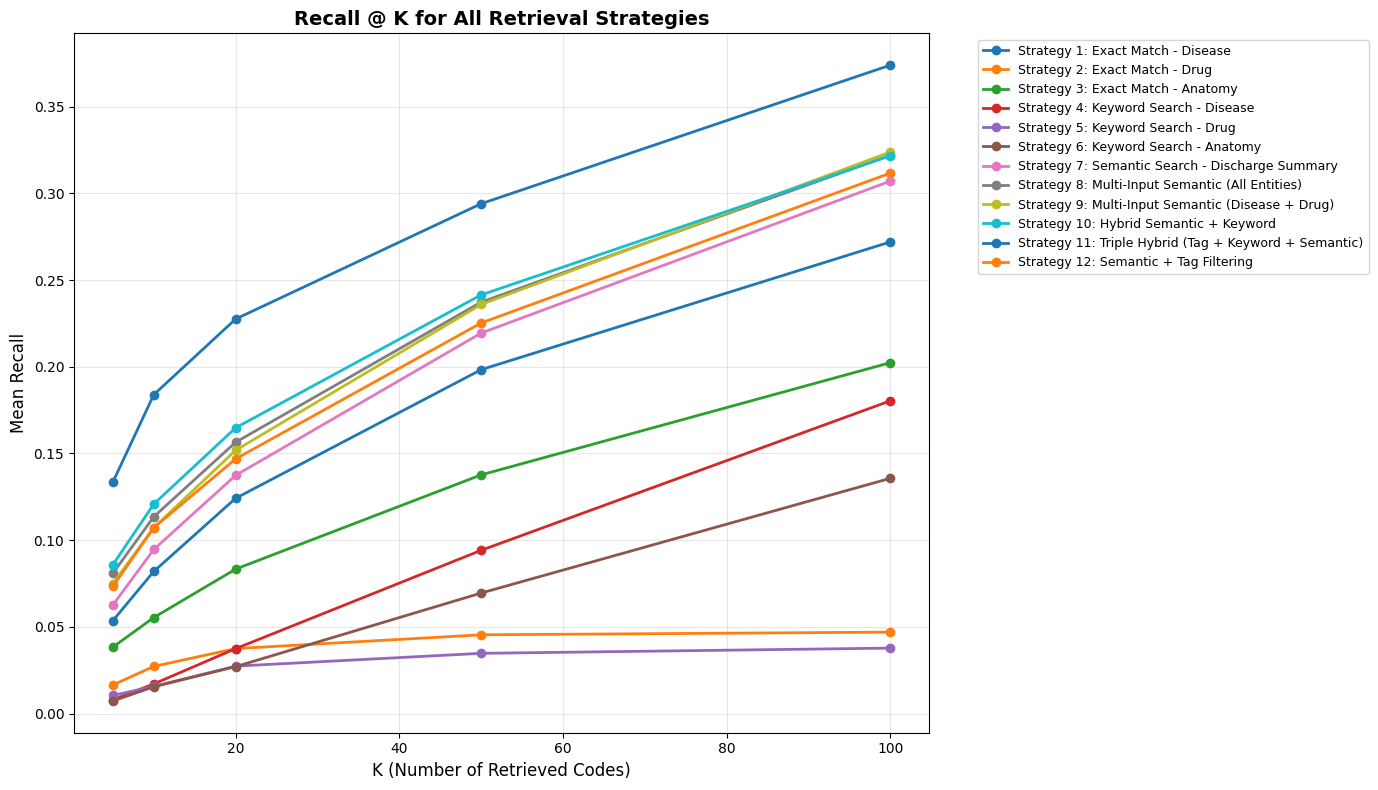

Recall @ K plot saved


In [23]:
# Visualization 1: Recall @ K curves
plt.figure(figsize=(14, 8))

for strategy_name in strategies.keys():
    strategy_data = results_df[results_df['strategy'] == strategy_name]
    strategy_data = strategy_data.sort_values('k')
    
    plt.plot(strategy_data['k'], strategy_data['mean_recall'], 
             marker='o', label=strategy_name, linewidth=2)

plt.xlabel('K (Number of Retrieved Codes)', fontsize=12)
plt.ylabel('Mean Recall', fontsize=12)
plt.title('Recall @ K for All Retrieval Strategies', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/evaluation/recall_at_k_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Recall @ K plot saved")

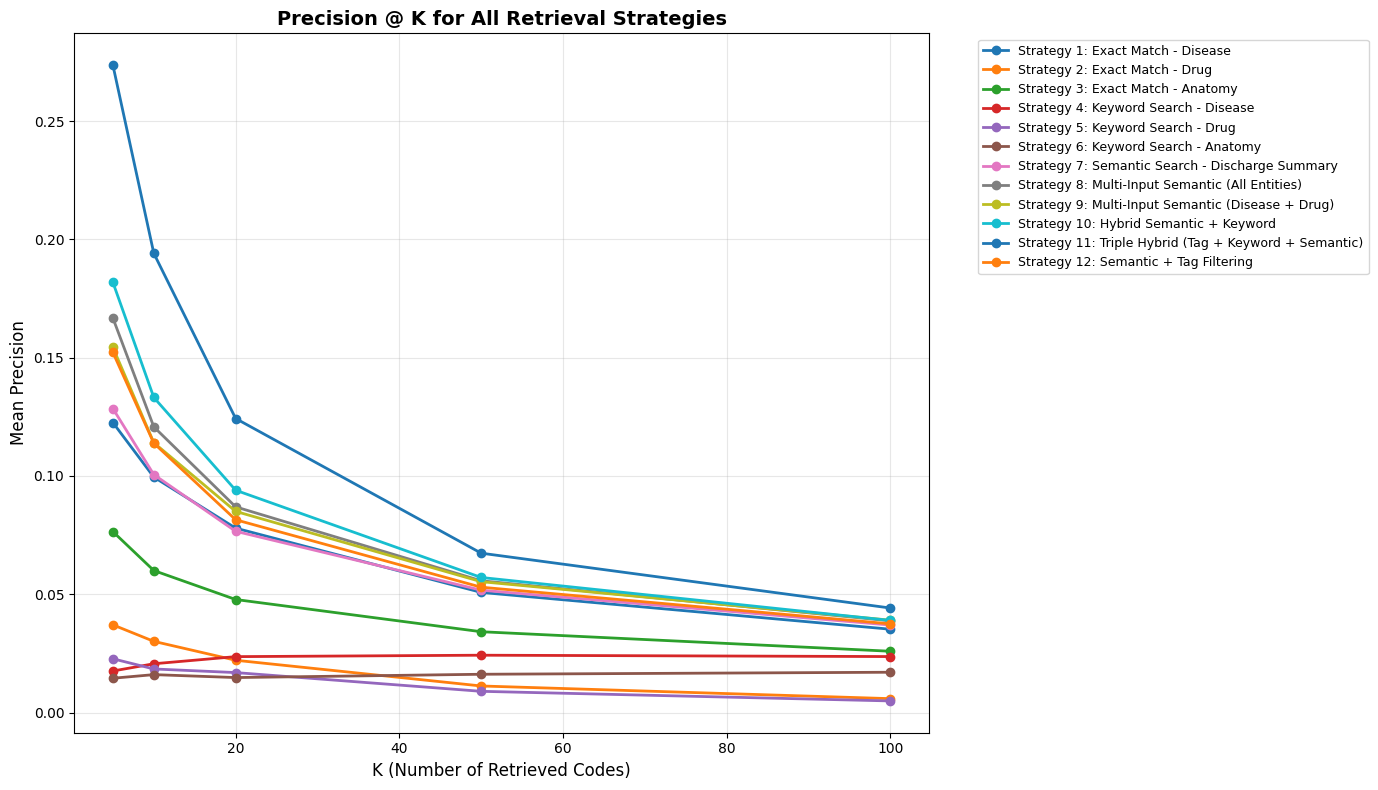

Precision @ K plot saved


In [24]:
# Visualization 2: Precision @ K curves
plt.figure(figsize=(14, 8))

for strategy_name in strategies.keys():
    strategy_data = results_df[results_df['strategy'] == strategy_name]
    strategy_data = strategy_data.sort_values('k')
    
    plt.plot(strategy_data['k'], strategy_data['mean_precision'], 
             marker='o', label=strategy_name, linewidth=2)

plt.xlabel('K (Number of Retrieved Codes)', fontsize=12)
plt.ylabel('Mean Precision', fontsize=12)
plt.title('Precision @ K for All Retrieval Strategies', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/evaluation/precision_at_k_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Precision @ K plot saved")

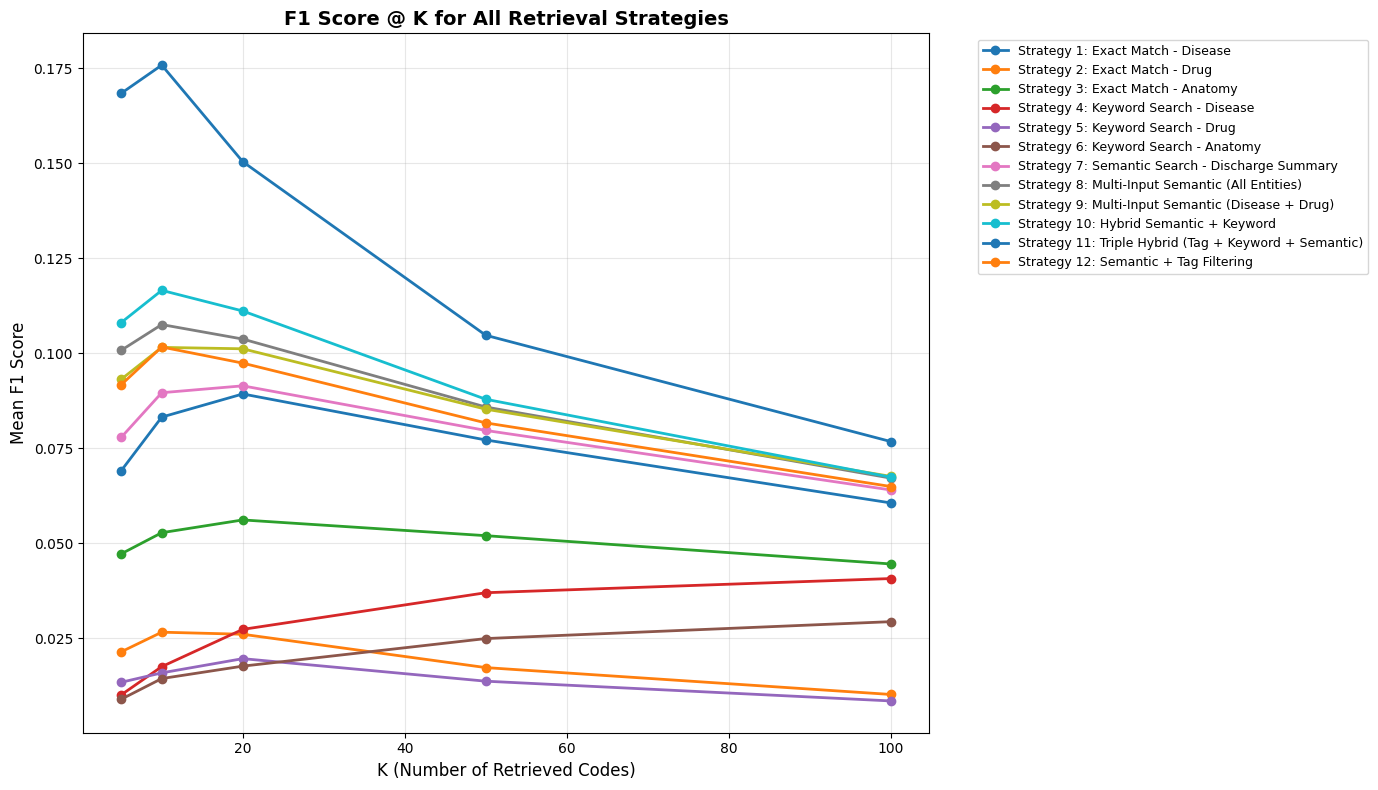

F1 @ K plot saved


In [25]:
# Visualization 3: F1 @ K curves
plt.figure(figsize=(14, 8))

for strategy_name in strategies.keys():
    strategy_data = results_df[results_df['strategy'] == strategy_name]
    strategy_data = strategy_data.sort_values('k')
    
    plt.plot(strategy_data['k'], strategy_data['mean_f1'], 
             marker='o', label=strategy_name, linewidth=2)

plt.xlabel('K (Number of Retrieved Codes)', fontsize=12)
plt.ylabel('Mean F1 Score', fontsize=12)
plt.title('F1 Score @ K for All Retrieval Strategies', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/evaluation/f1_at_k_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("F1 @ K plot saved")

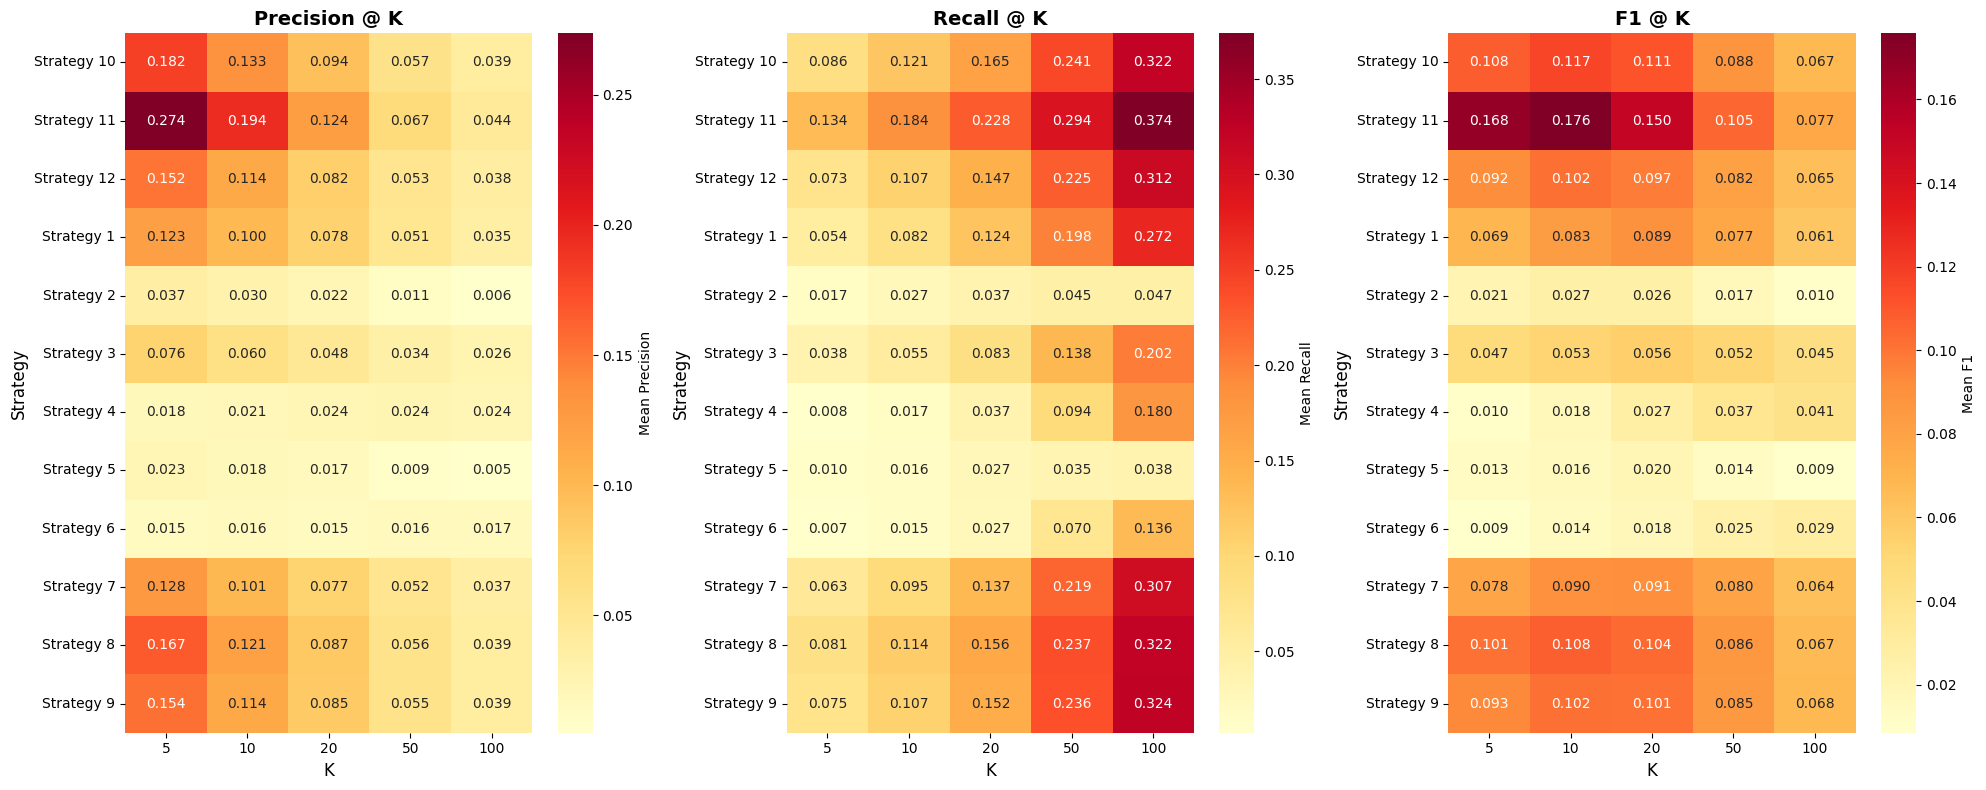

Heatmap saved


In [26]:
# Visualization 4: Heatmap showing best strategies per metric
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

k_values = [5, 10, 20, 50, 100]
strategy_names_short = [s.split(':')[0] for s in strategies.keys()]

for idx, (metric, ax) in enumerate(zip(['precision', 'recall', 'f1'], axes)):
    # Create matrix for heatmap
    heatmap_data = results_df.pivot(index='strategy', columns='k', values=f'mean_{metric}')
    
    # Shorten strategy names for better display
    heatmap_data.index = [s.split(':')[0] for s in heatmap_data.index]
    
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', 
                ax=ax, cbar_kws={'label': f'Mean {metric.capitalize()}'})
    ax.set_title(f'{metric.capitalize()} @ K', fontsize=14, fontweight='bold')
    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel('Strategy', fontsize=12)

plt.tight_layout()
plt.savefig('../results/evaluation/metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Heatmap saved")

TOP 5 STRATEGIES AT K=50 (sorted by F1 score)
                                             strategy  mean_precision  mean_recall  mean_f1
Strategy 11: Triple Hybrid (Tag + Keyword + Semantic)        0.067380     0.294044 0.104733
               Strategy 10: Hybrid Semantic + Keyword        0.057113     0.241455 0.087893
      Strategy 8: Multi-Input Semantic (All Entities)        0.055717     0.237315 0.085853
    Strategy 9: Multi-Input Semantic (Disease + Drug)        0.055335     0.235949 0.085284
                Strategy 12: Semantic + Tag Filtering        0.053002     0.225276 0.081676


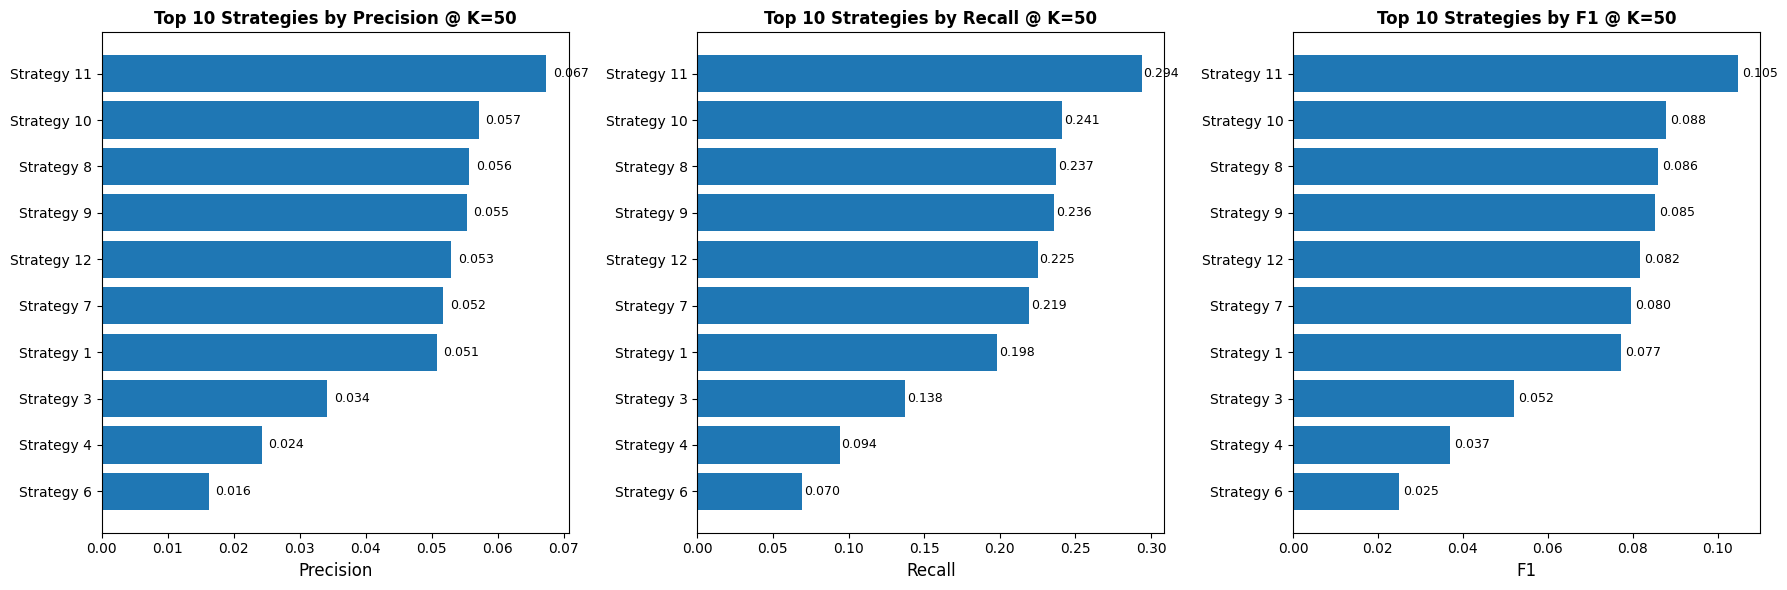


Top strategies comparison plot saved


In [27]:
# Additional analysis: Top strategies comparison at K=50
k50_results = results_df[results_df['k'] == 50].copy()
k50_results = k50_results.sort_values('mean_f1', ascending=False)

print("="*100)
print("TOP 5 STRATEGIES AT K=50 (sorted by F1 score)")
print("="*100)
print(k50_results[['strategy', 'mean_precision', 'mean_recall', 'mean_f1']].head().to_string(index=False))

# Bar plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (metric, ax) in enumerate(zip(['mean_precision', 'mean_recall', 'mean_f1'], axes)):
    top_strategies = k50_results.nlargest(10, metric)
    
    # Shorten names
    top_strategies['short_name'] = top_strategies['strategy'].apply(lambda x: x.split(':')[0])
    
    ax.barh(range(len(top_strategies)), top_strategies[metric])
    ax.set_yticks(range(len(top_strategies)))
    ax.set_yticklabels(top_strategies['short_name'], fontsize=10)
    ax.set_xlabel(metric.replace('mean_', '').replace('_', ' ').title(), fontsize=12)
    ax.set_title(f'Top 10 Strategies by {metric.replace("mean_", "").replace("_", " ").title()} @ K=50', 
                 fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(top_strategies[metric]):
        ax.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/evaluation/top_strategies_k50.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop strategies comparison plot saved")

# Evaluation Summary

This notebook evaluates 12 different retrieval strategies for ICD-10 code prediction:

## Strategies Tested:
1. **Exact Match - Disease**: Case-insensitive substring matching on disease entities
2. **Exact Match - Drug**: Case-insensitive substring matching on drug entities
3. **Exact Match - Anatomy**: Case-insensitive substring matching on anatomy entities
4. **Keyword Search - Disease**: ChromaDB keyword search on disease entities
5. **Keyword Search - Drug**: ChromaDB keyword search on drug entities
6. **Keyword Search - Anatomy**: ChromaDB keyword search on anatomy entities
7. **Semantic Search**: Plain semantic search using full discharge summary
8. **Multi-Input Semantic (All)**: Semantic search with discharge summary + all entities
9. **Multi-Input Semantic (Disease+Drug)**: Semantic search with discharge summary + disease + drug entities
10. **Hybrid Semantic + Keyword**: Combines semantic search with keyword matching boost
11. **Triple Hybrid**: Weighted combination of tag-based, keyword, and semantic approaches
12. **Semantic + Tag Filtering**: Semantic search with tag-based re-ranking

## Metrics Evaluated:
- **Precision @ K**: Proportion of retrieved codes that are correct
- **Recall @ K**: Proportion of true codes that were retrieved
- **F1 Score @ K**: Harmonic mean of precision and recall

## K Values Tested:
[5, 10, 20, 50, 100]

## Results:
See the visualizations and summary tables above for detailed performance comparison.